In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [42]:
%env TF_CPP_MIN_LOG_LEVEL=3
import tensorflow as tf
from tensorflow import keras
# tf.keras.backend.set_floatx('float64')

env: TF_CPP_MIN_LOG_LEVEL=3


> Downloading data

In [5]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

> Reading the file using pandas

In [5]:
climate_data = pd.read_csv('jena_climate_2009_2016.csv')
print(climate_data.shape)
climate_data.info()

(420451, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


> There are 15 columns in the data set. Let's take a look at the first five rows of it.

In [6]:
climate_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


> All the columns are numeric except for the "Date Time" column. Pandas describe() function can show some basic statistics about the columns.

In [7]:
climate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),420451.0,989.212508,8.359454,913.60,984.20,989.57,994.72,1015.35
T (degC),420451.0,9.448567,8.423685,-23.01,3.36,9.41,15.47,37.28
Tpot (K),420451.0,283.491182,8.504820,250.60,277.43,283.46,289.53,311.34
Tdew (degC),420451.0,4.954011,6.730411,-25.01,0.24,5.21,10.07,23.11
rh (%),420451.0,76.007045,16.477126,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420451.0,13.575089,7.739481,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420451.0,9.532524,4.183895,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420451.0,4.042483,4.897270,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420451.0,6.021630,2.655973,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420451.0,9.638982,4.235130,0.80,6.29,8.96,12.48,28.82


#### Preparing Data
- I am converting the "Date Time" column from object type to datetime type, so that it can be used for sampling by datetime.
- The temparature is recorded every 10 minutes and hence 6 records for each hour. I want to resample the data hourly and keep the last recorded temparature. 
- Beforehand, I am copying the data to a new dataframe so the original data stays unchanged. 

In [8]:
raw_data = climate_data.copy()
raw_data['Date Time'] = pd.to_datetime(raw_data['Date Time'], dayfirst=True)
raw_data.isna().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [9]:
# sampling for each hour, keeping the last value
# this might introduce some null values if there aren't data for every hour
raw_data = raw_data.resample('H', on='Date Time').last()
print('raw_data shape after hourly sampling: ', raw_data.shape)
print(raw_data.isna().sum())

raw_data shape after hourly sampling:  (70129, 14)
p (mbar)           104
T (degC)           104
Tpot (K)           104
Tdew (degC)        104
rh (%)             104
VPmax (mbar)       104
VPact (mbar)       104
VPdef (mbar)       104
sh (g/kg)          104
H2OC (mmol/mol)    104
rho (g/m**3)       104
wv (m/s)           104
max. wv (m/s)      104
wd (deg)           104
dtype: int64


In [12]:
raw_data.dropna(inplace=True)
print('raw_data shape after dropping na: ', raw_data.shape)
raw_data.head()

raw_data shape after dropping na:  (70025, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
2009-01-01 01:00:00,996.62,-8.76,264.66,-9.66,93.1,3.14,2.93,0.22,1.83,2.94,1311.64,0.45,0.88,183.2
2009-01-01 02:00:00,996.86,-8.70,264.70,-9.55,93.5,3.16,2.95,0.21,1.85,2.96,1311.64,0.32,0.63,219.2
2009-01-01 03:00:00,997.06,-8.99,264.39,-9.99,92.4,3.09,2.85,0.23,1.78,2.86,1313.39,0.12,0.63,231.7
2009-01-01 04:00:00,997.37,-9.47,263.89,-10.46,92.4,2.97,2.75,0.23,1.72,2.75,1316.25,0.37,0.75,125.8


> Copying the target column that I want to forecast, in this case this is the temparature column. This will be used when I create and split the dataset for train, validation and test set.

In [11]:
temparature = raw_data['T (degC)'].values.tolist()

#### Visualizing the columns together

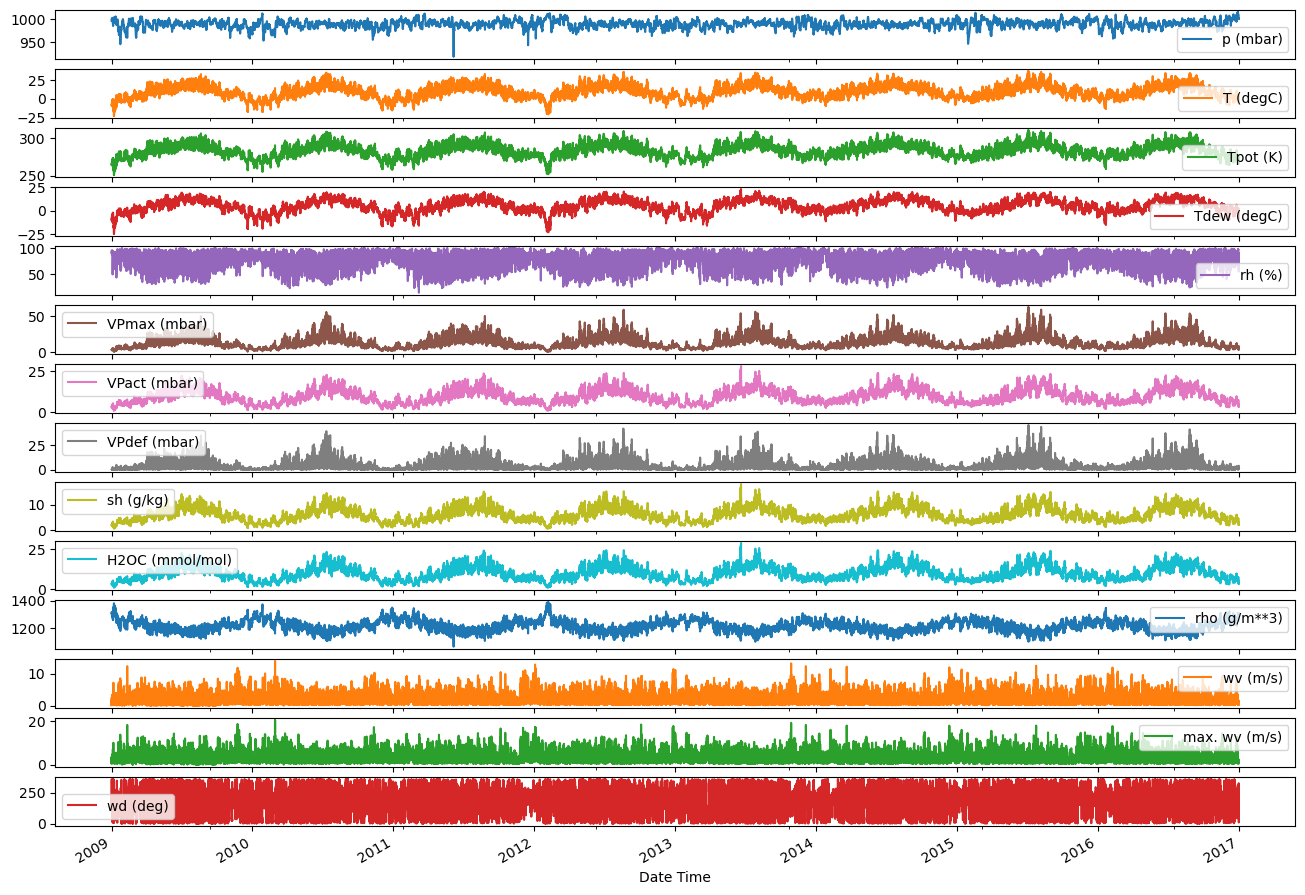

In [33]:
raw_data.plot(subplots=True, figsize=(16, 12))
plt.show()

#### Split data and normalize
I am going to use 50% data for training and 25% for validation and rest of the 25% for testing

In [34]:
# computing the number of samples for each data split

num_train_sample = int(0.5 * len(raw_data))
num_val_sample = int(0.25 * len(raw_data))
num_test_sample = len(raw_data)-num_train_sample-num_val_sample

print('Train set size: ', num_train_sample)
print('Validation set size: ', num_val_sample)
print('Test set size: ', num_test_sample)

Train set size:  35012
Validation set size:  17506
Test set size:  17507


The columns are in different scales. I am normalizing the data based on the training set.

In [35]:
# normalization using the training data
train_mean = raw_data[:num_train_sample].mean(axis=0)
train_std = raw_data[:num_train_sample].std(axis=0)
print('mean value from train set:\n', train_mean)
print('std value from train set:\n', train_std)

raw_data -= train_mean
raw_data /= train_std
raw_data.head()

mean value from train set:
 p (mbar)            988.748571
T (degC)              8.817903
Tpot (K)            282.897095
Tdew (degC)           4.307453
rh (%)               75.879440
VPmax (mbar)         13.135387
VPact (mbar)          9.189778
VPdef (mbar)          3.945548
sh (g/kg)             5.807737
H2OC (mmol/mol)       9.297677
rho (g/m**3)       1218.485714
wv (m/s)              2.153232
max. wv (m/s)         3.562659
wd (deg)            176.293149
dtype: float64
std value from train set:
 p (mbar)            8.507360
T (degC)            8.763298
Tpot (K)            8.858137
Tdew (degC)         7.077409
rh (%)             16.625546
VPmax (mbar)        7.588712
VPact (mbar)        4.144056
VPdef (mbar)        4.760673
sh (g/kg)           2.630954
H2OC (mmol/mol)     4.196844
rho (g/m**3)       42.011910
wv (m/s)            1.532254
max. wv (m/s)       2.323949
wd (deg)           85.807788
dtype: float64


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,0.912319,-1.949940,-2.003479,-1.885924,1.095938,-1.300008,-1.474347,-0.788869,-1.477691,-1.479130,2.154491,-1.196428,-1.261929,0.442930
2009-01-01 01:00:00,0.925249,-2.005855,-2.058796,-1.973526,1.035789,-1.317139,-1.510544,-0.782567,-1.511899,-1.514871,2.217330,-1.111586,-1.154353,0.080492
2009-01-01 02:00:00,0.953460,-1.999008,-2.054280,-1.957984,1.059849,-1.314503,-1.505717,-0.784668,-1.504297,-1.510105,2.217330,-1.196428,-1.261929,0.500034
2009-01-01 03:00:00,0.976969,-2.032101,-2.089276,-2.020154,0.993685,-1.323728,-1.529848,-0.780467,-1.530903,-1.533933,2.258985,-1.326955,-1.261929,0.645709
2009-01-01 04:00:00,1.013408,-2.086875,-2.145721,-2.086562,0.993685,-1.339541,-1.553979,-0.780467,-1.553709,-1.560143,2.327061,-1.163796,-1.210293,-0.588445


In [36]:
raw_data = raw_data.sort_index()
raw_data = raw_data.reset_index()
raw_data = raw_data.drop(columns=['Date Time'])
# print(raw_data.info())
raw_data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0.912319,-1.949940,-2.003479,-1.885924,1.095938,-1.300008,-1.474347,-0.788869,-1.477691,-1.479130,2.154491,-1.196428,-1.261929,0.442930
1,0.925249,-2.005855,-2.058796,-1.973526,1.035789,-1.317139,-1.510544,-0.782567,-1.511899,-1.514871,2.217330,-1.111586,-1.154353,0.080492
2,0.953460,-1.999008,-2.054280,-1.957984,1.059849,-1.314503,-1.505717,-0.784668,-1.504297,-1.510105,2.217330,-1.196428,-1.261929,0.500034
3,0.976969,-2.032101,-2.089276,-2.020154,0.993685,-1.323728,-1.529848,-0.780467,-1.530903,-1.533933,2.258985,-1.326955,-1.261929,0.645709
4,1.013408,-2.086875,-2.145721,-2.086562,0.993685,-1.339541,-1.553979,-0.780467,-1.553709,-1.560143,2.327061,-1.163796,-1.210293,-0.588445


#### Generating Datasets

>I am using timeseries_dataset_from_array() function from keras and instantiating three datasets namely training, validation and testing.
Since I have formulated my problem as to predict the temparature in 24 hours while taking input from the previous five days of data, the length of the sequence and the offset of the target will be set as follows: \
sequence_length = 120 # observations will go back 5 days (5 * 24 hours) \
delay = (sequence_length + 24 - 1) # the target for a sequence will be the temparature 24 hours after the end of the sequence.


In [43]:
# creating train, validation and testing data sets
sequence_length = 120
delay = (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temparature[delay:],    
    sequence_length = sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_sample
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temparature[delay:],    
    sequence_length = sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_sample,
    end_index=num_train_sample+num_val_sample
)


test_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data[:-delay],
    targets = temparature[delay:],
    sequence_length = sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_sample+num_val_sample    
)


> Let's inspect output of one of our datasets

In [44]:
for samples, targets in train_dataset:
    print('sample shape: ', samples.shape)
    print('target shape: ', targets.shape)
    print(samples[0])
    print(targets[0])
    break

sample shape:  (256, 120, 14)
target shape:  (256,)
tf.Tensor(
[[-2.00515456 -0.00546632  0.15385906 ...  0.35031256 -0.06999229
  -0.35070418]
 [-2.04747087  0.0949525   0.25658946 ...  1.06820901  0.75618764
   0.25297063]
 [-2.03218998  0.17140773  0.33222613 ...  0.25894392  0.13655269
   0.25530143]
 ...
 [-1.04716051  0.98160501  1.05924127 ... -0.04126732 -0.27653728
  -0.11879049]
 [-1.05656413  1.13793885  1.21503023 ... -0.15874129  0.17097685
   0.04669565]
 [-1.07302047  1.19841836  1.27712003 ... -0.21095194 -0.31096144
  -0.00924333]], shape=(120, 14), dtype=float64)
tf.Tensor(13.44, shape=(), dtype=float32)


#### Setting the baseline model
> Building a naive method to set a baseline. The naive method will predict that the temparature 24 hours from now will be equal to the temparature right now.

In [48]:
def evaluate_naive_method(dataset, std, mean):
    total_abs_err = 0
    sample_seen = 0
    for samples, targets in dataset:        
        preds = samples[:, -1, 1] * std[1] * 1.0 + mean[1]        
        targets = tf.cast(targets, dtype=tf.float64)       
        total_abs_err += np.sum(np.abs(preds-targets))
        sample_seen += samples.shape[0]
        # break
        
    mae = total_abs_err/sample_seen
    
    return mae


In [50]:
print(f"Validation MAE from Naive method: {evaluate_naive_method(val_dataset, train_std, train_mean)}")
print(f"Test MAE from Naive method: {evaluate_naive_method(test_dataset, train_std, train_mean)}")

Validation MAE from Naive method: 2.4415597882153115
Test MAE from Naive method: 2.6256990494462675


#### Deep learning method 1: densely connected network
> Starting with a small densely connected network. I need to check the results before jumping into complicated and computationally more expensive techniques like RNN. This way, I can make sure that further complexity added to the problem will be legitimate and can offer real benefits.

In [51]:
# deep learning method 1
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = tf.keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)


Epoch 1/20
137/137 [==============================] - 8s 51ms/step - loss: 24.0363 - mae: 3.7514 - val_loss: 11.8452 - val_mae: 2.7217
Epoch 2/20
137/137 [==============================] - 8s 58ms/step - loss: 11.1548 - mae: 2.6291 - val_loss: 10.9115 - val_mae: 2.6146
Epoch 3/20
137/137 [==============================] - 8s 58ms/step - loss: 9.9637 - mae: 2.4794 - val_loss: 10.4533 - val_mae: 2.5569
Epoch 4/20
137/137 [==============================] - 7s 50ms/step - loss: 9.3067 - mae: 2.3924 - val_loss: 10.4357 - val_mae: 2.5519
Epoch 5/20
137/137 [==============================] - 7s 49ms/step - loss: 8.9410 - mae: 2.3458 - val_loss: 10.4358 - val_mae: 2.5543
Epoch 6/20
137/137 [==============================] - 7s 53ms/step - loss: 8.6496 - mae: 2.3080 - val_loss: 10.5709 - val_mae: 2.5641
Epoch 7/20
137/137 [==============================] - 9s 61ms/step - loss: 8.3294 - mae: 2.2661 - val_loss: 10.2701 - val_mae: 2.5260
Epoch 8/20
137/137 [==============================] - 8s 55m

In [53]:
def plot_metrics(history, start_index=0, model_name=None):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(start_index+1, len(loss)+1)
    plt.figure()
    plt.plot(epochs, loss[start_index:], 'bo', label='Training MAE')
    plt.plot(epochs, val_loss[start_index:], 'b', label='Validation MAE')
    plt.title('Training and validation MAE from '+model_name+' Model')
    plt.legend()
    plt.show()

68/68 [==============================] - 2s 34ms/step - loss: 11.2240 - mae: 2.6391
Test MAE from dense model: 2.64


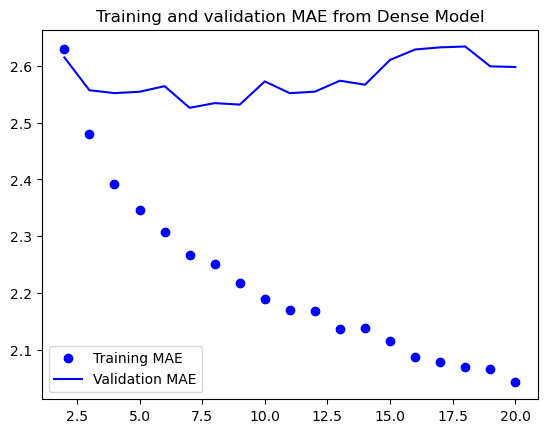

In [52]:
model = keras.models.load_model('jena_dense.keras')
print(f"Test MAE from dense model: {model.evaluate(test_dataset)[1]:.2f}")
plot_metrics(history, start_index=1, model_name='Dense')

* Observations: 
    - The test error from the dense network is higher than the what we got from the naive method.
    - The training error continuously going down while the validation error is not improving.

<div class="alert alert-block alert-info">
<b>Note:</b> The naive method outperformed the dense network! </div>

#### Deep learning method 2: convolutional neural network
> I am using a 1D conv network with window length of 24 to cover 24 hours cycle period

In [25]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs) # filters=8, kernel_size=24
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks_conv = tf.keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs=20,
                   validation_data=val_dataset,
                   callbacks=callbacks_conv)



Epoch 1/20
137/137 [==============================] - 7s 43ms/step - loss: 45.1268 - mae: 5.1368 - val_loss: 21.7590 - val_mae: 3.6664
Epoch 2/20
137/137 [==============================] - 6s 42ms/step - loss: 23.0103 - mae: 3.8235 - val_loss: 19.4280 - val_mae: 3.4866
Epoch 3/20
137/137 [==============================] - 6s 42ms/step - loss: 20.8344 - mae: 3.6318 - val_loss: 17.9253 - val_mae: 3.3192
Epoch 4/20
137/137 [==============================] - 6s 43ms/step - loss: 18.4134 - mae: 3.4110 - val_loss: 15.8029 - val_mae: 3.1551
Epoch 5/20
137/137 [==============================] - 5s 34ms/step - loss: 16.5717 - mae: 3.2331 - val_loss: 16.0206 - val_mae: 3.1513
Epoch 6/20
137/137 [==============================] - 5s 33ms/step - loss: 15.5335 - mae: 3.1328 - val_loss: 15.7834 - val_mae: 3.1473
Epoch 7/20
137/137 [==============================] - 5s 33ms/step - loss: 14.9374 - mae: 3.0738 - val_loss: 15.3583 - val_mae: 3.1275
Epoch 8/20
137/137 [==============================] - 5

68/68 [==============================] - 1s 16ms/step - loss: 16.8175 - mae: 3.2424
Test MAE from Conv1D model: 3.24


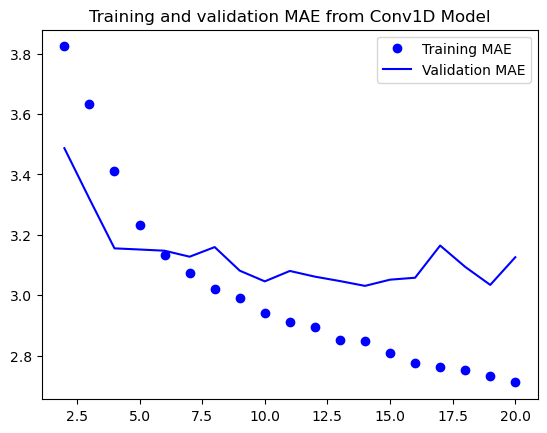

In [26]:
model = keras.models.load_model('jena_conv.keras')
print(f"Test MAE from Conv1D model: {model.evaluate(test_dataset)[1]:.2f}")
plot_metrics(history, start_index=1, model_name='Conv1D')

* Observations: 
    - The error values are even worse for the cnn based model!
    - This is actually understandable as cnn looses the order information, which is an important property to maintain in this specific use case.

<div class="alert alert-block alert-info">
<b>Note:</b> The naive method is still the best! </div>

#### Deep learning method 3: first try with recurrent neural network model
> Starting with a GRU-based model

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback_gru = tf.keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs=20,
                   validation_data=val_dataset,
                   callbacks=callback_gru)



Epoch 1/20
137/137 [==============================] - 12s 79ms/step - loss: 99.4147 - mae: 8.2722 - val_loss: 62.0221 - val_mae: 6.1424
Epoch 2/20
137/137 [==============================] - 11s 77ms/step - loss: 48.5998 - mae: 5.3119 - val_loss: 41.3066 - val_mae: 4.8560
Epoch 3/20
137/137 [==============================] - 10s 76ms/step - loss: 34.2829 - mae: 4.3689 - val_loss: 30.0915 - val_mae: 4.0570
Epoch 4/20
137/137 [==============================] - 11s 78ms/step - loss: 25.9850 - mae: 3.7801 - val_loss: 23.6004 - val_mae: 3.5723
Epoch 5/20
137/137 [==============================] - 11s 77ms/step - loss: 20.9932 - mae: 3.4015 - val_loss: 19.5515 - val_mae: 3.2478
Epoch 6/20
137/137 [==============================] - 11s 77ms/step - loss: 17.8494 - mae: 3.1566 - val_loss: 17.0802 - val_mae: 3.0493
Epoch 7/20
137/137 [==============================] - 10s 76ms/step - loss: 15.7876 - mae: 2.9864 - val_loss: 15.2970 - val_mae: 2.8965
Epoch 8/20
137/137 [============================

68/68 [==============================] - 2s 32ms/step - loss: 11.2853 - mae: 2.6003
Test MAE from GRU model: 2.60


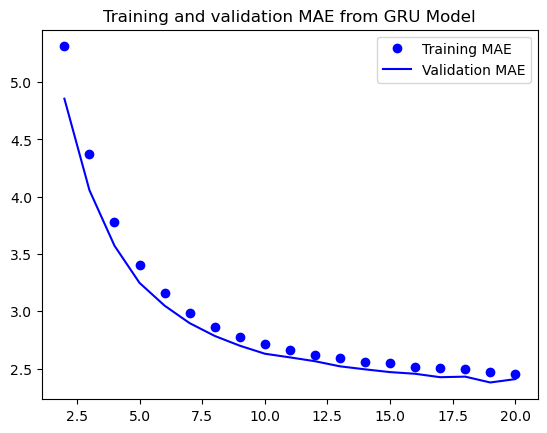

In [30]:
model = keras.models.load_model('jena_gru.keras')
print(f"Test MAE from GRU model: {model.evaluate(test_dataset)[1]:.2f}")
plot_metrics(history, start_index=1, model_name='GRU')

* Observations: 
    - Finally a model with lower test error than the naive one!
    - The training error and the validation error both are improving.

<div class="alert alert-block alert-info">
<b>Note:</b> The rnn model outperformed the naive method! </div>

#### Further improvement
- Adding dropout to prevent the model from overfitting
- Network with dropout regularizer usually takes longer to fully converge hence increasing the number of epochs
- Also changing the optimizer to check whether it performs better

In [115]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callback_gru_dropout = tf.keras.callbacks.ModelCheckpoint("jena_gru_dropout.keras", save_best_only=True)

model.compile(optimizer='sgd', loss='mse', metrics=['mae'])

history = model.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset,
                   callbacks=callback_gru_dropout)



Epoch 1/50
137/137 [==============================] - 24s 165ms/step - loss: 20.6789 - mae: 3.4255 - val_loss: 10.3492 - val_mae: 2.4897
Epoch 2/50
137/137 [==============================] - 23s 165ms/step - loss: 14.9802 - mae: 3.0163 - val_loss: 9.6055 - val_mae: 2.4123
Epoch 3/50
137/137 [==============================] - 23s 164ms/step - loss: 14.4822 - mae: 2.9641 - val_loss: 9.8920 - val_mae: 2.4455
Epoch 4/50
137/137 [==============================] - 23s 165ms/step - loss: 14.0878 - mae: 2.9222 - val_loss: 9.5042 - val_mae: 2.4055
Epoch 5/50
137/137 [==============================] - 22s 162ms/step - loss: 13.9783 - mae: 2.9089 - val_loss: 9.3532 - val_mae: 2.3840
Epoch 6/50
137/137 [==============================] - 22s 163ms/step - loss: 13.7153 - mae: 2.8775 - val_loss: 9.3812 - val_mae: 2.3847
Epoch 7/50
137/137 [==============================] - 23s 165ms/step - loss: 13.6670 - mae: 2.8820 - val_loss: 9.9359 - val_mae: 2.4618
Epoch 8/50
137/137 [===========================

68/68 [==============================] - 4s 51ms/step - loss: 9.9158 - mae: 2.4424
Test MAE from LSTM model with dropout: 2.44


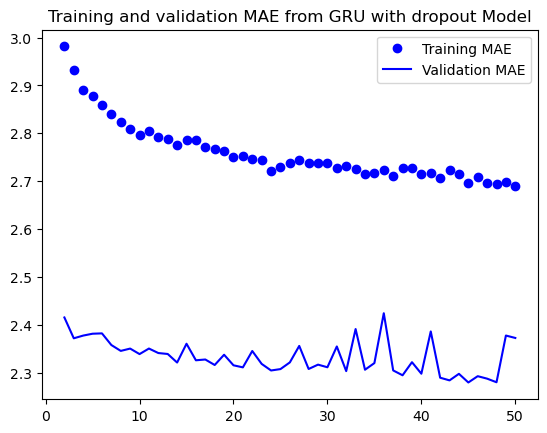

In [118]:
model = keras.models.load_model('jena_gru_dropout.keras')
print(f"Test MAE from GRU model with dropout: {model.evaluate(test_dataset)[1]:.2f}")
plot_metrics(history, start_index=1, model_name='GRU with dropout')

* Observations: 
    - The error metrics on test has improved
    - The validation error is lowest around 2.3 with this model.

<div class="alert alert-block alert-info">
<b>Note:</b> Adding regularization helped in achieving better performance on test data! </div>